In [1]:
import os
from pathlib import Path
import sys
import logging

logging.basicConfig(level=logging.INFO)


In [2]:
sys.path.append('..')


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpxshu6dq3
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpxshu6dq3/_remote_module_non_scriptable.py


In [5]:
import baard.utils.torch_utils as utils
from baard.classifiers import MNIST_CNN


In [6]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
PATH_CHECKPOINT = os.path.join(PATH_ROOT, 'pretrained_clf')
print('ROOT:', PATH_ROOT)
print('CHECKPOINT:', PATH_CHECKPOINT)


ROOT: /home/lukec/workspace/baard_v4
CHECKPOINT: /home/lukec/workspace/baard_v4/pretrained_clf


In [7]:
path_checkpoint = os.path.join(PATH_CHECKPOINT, 'mnist_cnn.ckpt')
model = MNIST_CNN.load_from_checkpoint(path_checkpoint)


In [8]:
path_val = os.path.join(PATH_ROOT, 'results', 'exp1234', 'MNIST', 'ValClean-1000.pt')
path_clean = os.path.join(PATH_ROOT, 'results', 'exp1234', 'MNIST', 'AdvClean-100.pt')

X_val, y_val = utils.dataset2tensor(torch.load(path_val))
X_clean, y_clean = utils.dataset2tensor(torch.load(path_clean))

print(X_val.shape, X_clean.shape)


torch.Size([1000, 1, 28, 28]) torch.Size([100, 1, 28, 28])


In [9]:
print('True:', y_clean[:10])
_pred = torch.argmax(model(X_clean[:10]), 1)
print('Pred:', _pred)


True: tensor([9, 7, 5, 5, 5, 7, 5, 0, 5, 8])
Pred: tensor([9, 7, 5, 5, 5, 7, 5, 0, 5, 8])


In [10]:
from baard.attacks.adaptive_whitebox import targeted_whitebox_pgd


In [11]:
# Find the nearest example with a different label in the validation set.
indices_target = torch.where(y_val != y_clean[0])[0]
X_target = X_val[indices_target]
y_target = y_val[indices_target]

cosine_sim_fn = torch.nn.CosineSimilarity(dim=1)
cos_sim_target = cosine_sim_fn(
    X_target.reshape(len(X_target), -1),
    X_clean[0].flatten(),
)
angular_dist_target = torch.arccos(cos_sim_target) / torch.pi
idx_nearest = torch.argmin(angular_dist_target)
print('Mean: {:.3f} Dist: {:.3f}, Idx: {}'.format(
    angular_dist_target.mean(),
    angular_dist_target[idx_nearest],
    idx_nearest
))


Mean: 0.374 Dist: 0.233, Idx: 282


In [12]:
x_near_target = X_target[idx_nearest]
y_near_target = y_target[idx_nearest]
print(y_near_target)


tensor(7)


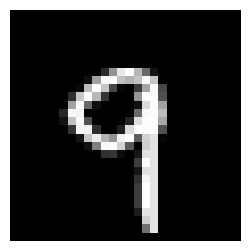

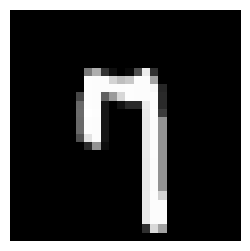

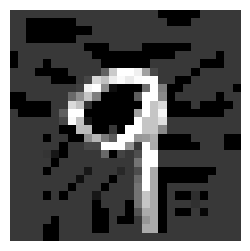

Pred: tensor([7])


In [13]:
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=0.22,
    eps_iter=0.03,
    nb_iter=100,
    early_stop=False,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))


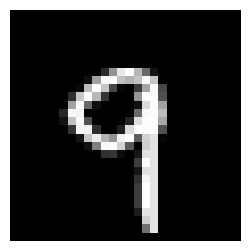

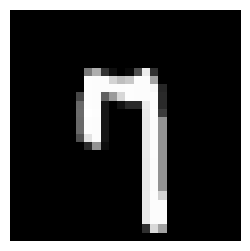

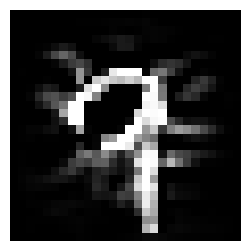

Pred: tensor([7])


In [14]:
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=4,
    eps_iter=0.1,
    nb_iter=100,
    norm=2,
    early_stop=False,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))


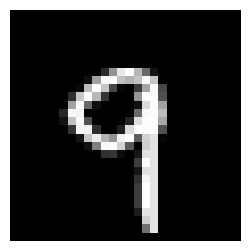

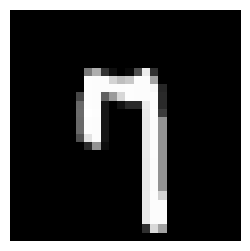

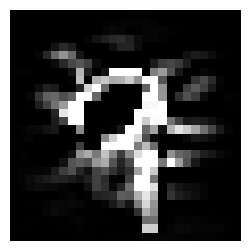

Pred: tensor([7])


In [15]:
# With larger c value. More weight toward the targeted example.
X_adv = targeted_whitebox_pgd(
    model,
    X_clean[0].unsqueeze(0),
    X_target[idx_nearest].unsqueeze(0),
    eps=10,
    eps_iter=0.1,
    nb_iter=100,
    norm=2,
    early_stop=False,
    rand_init=False,
    c=10,
)
utils.show_img(X_clean[0])
utils.show_img(X_target[idx_nearest])
utils.show_img(X_adv[0])
print('Pred:', torch.argmax(model(X_adv), 1))
